In [46]:
import numpy as np
def stadium_mask(X, Y, a, b, rx, ry):
    rect = (np.abs(X) <= a) & (np.abs(Y) <= b)
    left_ellipse = ((X + a)**2 / rx**2 + Y**2 / ry**2 <= 1) & (X <= -a)
    right_ellipse = ((X - a)**2 / rx**2 + Y**2 / ry**2 <= 1) & (X >= a)
    return rect | left_ellipse | right_ellipse

Loschmidt echo a=1.100: 100%|██████████| 2000/2000 [00:02<00:00, 690.73it/s]


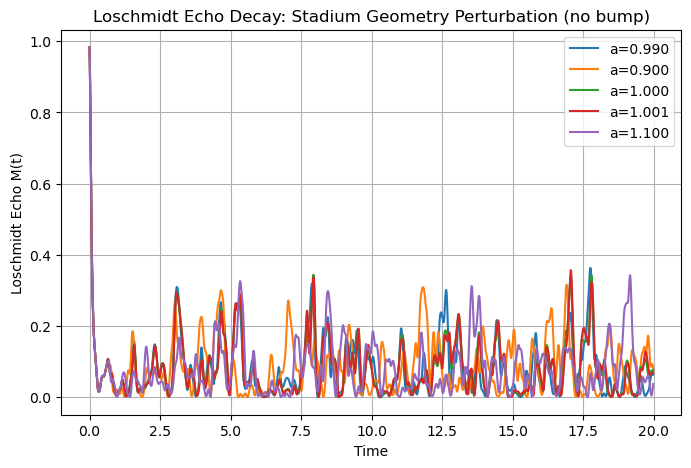

In [57]:
# Loschmidt echo with only stadium geometry perturbation (varying 'a', no bump)
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse import csr_matrix, eye
from scipy.sparse.linalg import splu

# Parameters for echo
a=1
echo_steps = 2000
perturbations_a = [a*0.99, a*0.90, a, a*1.001, a*1.10] 
echo_results = {}
a = 1.0
b = 1.0
rx = 2.0
ry = b
hbar = 1.0
m = 1.0
Nx, Ny = 256, 256  # coarser grid for sparse solving
dt = 0.01

T_steps = 15000
sigma = 0.2
x0, y0 = 0,0
px, py = 1.0, 1.0

# Define grid
x = np.linspace(-a - rx, a + rx, Nx) * 1.5
y = np.linspace(-b - ry, b + ry, Ny) * 1.5
dx = (x.max() - x.min()) / (Nx - 1)  # Compute actual dx
dy = (y.max() - y.min()) / (Ny - 1)  # Compute actual dy
X, Y = np.meshgrid(x, y)

# Define initial Gaussian wavepacket and flatten
psi0 = np.exp(-((X-x0)**2 + (Y-y0)**2)/(2*sigma**2)) * np.exp(1j * (px*X + py*Y))
psi0_flat = psi0.flatten()

# Build 2D Laplacian operator for Nx x Ny grid
from scipy.sparse import diags, kron, identity

main_diag_x = -2.0 * np.ones(Nx)
off_diag_x = np.ones(Nx - 1)
Lx = diags([main_diag_x, off_diag_x, off_diag_x], [0, -1, 1], shape=(Nx, Nx)) / dx**2

main_diag_y = -2.0 * np.ones(Ny)
off_diag_y = np.ones(Ny - 1)
Ly = diags([main_diag_y, off_diag_y, off_diag_y], [0, -1, 1], shape=(Ny, Ny)) / dy**2

L = kron(identity(Ny), Lx) + kron(Ly, identity(Nx))

for a_p in perturbations_a:
    # Recompute mask and free points for perturbed stadiumi
    mask_pert = stadium_mask(X, Y, a_p, b, rx, ry)
    free_points_pert = np.where(mask_pert.flatten())[0]
    Nfree_pert = len(free_points_pert)

    # Project initial wavepacket to perturbed stadium
    psi0_pert = psi0_flat[free_points_pert]
    norm_init_pert = np.sum(np.abs(psi0_pert)**2) * dx * dy
    psi0_pert /= np.sqrt(norm_init_pert)

    # Build Laplacian and Hamiltonian for perturbed stadium
    # Use same Laplacian construction as initial
    mask_full_pert = np.zeros(Nx*Ny, dtype=bool)
    mask_full_pert[free_points_pert] = True
    rows_pert, cols_pert, data_pert = [], [], []
    for i, idx in enumerate(free_points_pert):
        rows_pert.append(i)
        cols_pert.append(idx)
        data_pert.append(1)
    P_pert = csr_matrix((data_pert, (rows_pert, cols_pert)), shape=(Nfree_pert, Nx*Ny))
    L_pert = P_pert @ L @ P_pert.T
    I_pert = eye(Nfree_pert)
    H_pert = - (hbar**2) / (2*m) * L_pert

    # Crank-Nicolson matrices for perturbed stadium
    A_pert = (I_pert + 1j * dt / (2*hbar) * H_pert).tocsc()
    B_pert = (I_pert - 1j * dt / (2*hbar) * H_pert).tocsc()
    LU_pert = splu(A_pert)

    # Loschmidt echo evolution
    psi_bwd = psi0_pert.copy()
    M_t = []
    for t in tqdm(range(echo_steps), desc=f'Loschmidt echo a={a_p:.3f}'):
        b_vec = B_pert @ psi_bwd
        psi_bwd = LU_pert.solve(b_vec)
        overlap = np.vdot(psi0_pert, psi_bwd) * dx * dy
        M_t.append(np.abs(overlap)**2)
    echo_results[a_p] = M_t

# Plot Loschmidt echo for all a perturbations
times_echo = np.arange(echo_steps) * dt
plt.figure(figsize=(8,5))
for a_p, M_t in echo_results.items():
    plt.plot(times_echo, M_t, label=f'a={a_p:.3f}')
plt.xlabel('Time')
plt.ylabel('Loschmidt Echo M(t)')
plt.title('Loschmidt Echo Decay: Stadium Geometry Perturbation (no bump)')
plt.legend()
plt.grid(True)
plt.show()

Loschmidt echo a=3.000: 100%|██████████| 2000/2000 [00:05<00:00, 333.70it/s]


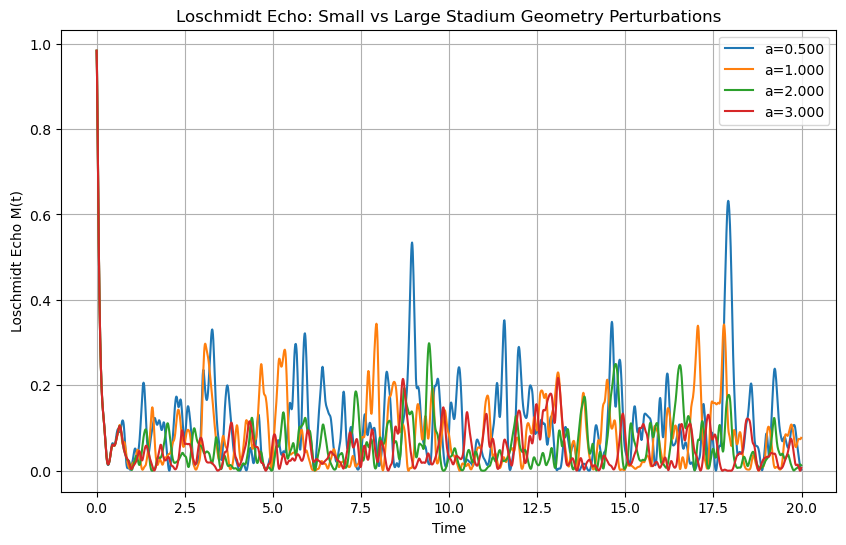

In [58]:
# Compare Loschmidt echo for smaller and larger stadium geometry perturbations
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Parameters for echo
# Use a range of small and large perturbations
perturbations_a = [a*0.5,a , a*2,a*3]
echo_steps = 2000
echo_results = {}

for a_p in perturbations_a:
    # Recompute mask and free points for perturbed stadium
    mask_pert = stadium_mask(X, Y, a_p, b, rx, ry)
    free_points_pert = np.where(mask_pert.flatten())[0]
    Nfree_pert = len(free_points_pert)

    # Project initial wavepacket to perturbed stadium
    psi0_pert = psi0_flat[free_points_pert]
    norm_init_pert = np.sum(np.abs(psi0_pert)**2) * dx * dy
    psi0_pert /= np.sqrt(norm_init_pert)

    # Build Laplacian and Hamiltonian for perturbed stadium
    mask_full_pert = np.zeros(Nx*Ny, dtype=bool)
    mask_full_pert[free_points_pert] = True
    rows_pert, cols_pert, data_pert = [], [], []
    for i, idx in enumerate(free_points_pert):
        rows_pert.append(i)
        cols_pert.append(idx)
        data_pert.append(1)
    P_pert = csr_matrix((data_pert, (rows_pert, cols_pert)), shape=(Nfree_pert, Nx*Ny))
    L_pert = P_pert @ L @ P_pert.T
    I_pert = eye(Nfree_pert)
    H_pert = - (hbar**2) / (2*m) * L_pert

    # Crank-Nicolson matrices for perturbed stadium
    A_pert = (I_pert + 1j * dt / (2*hbar) * H_pert).tocsc()
    B_pert = (I_pert - 1j * dt / (2*hbar) * H_pert).tocsc()
    LU_pert = splu(A_pert)

    # Loschmidt echo evolution
    psi_bwd = psi0_pert.copy()
    M_t = []
    for t in tqdm(range(echo_steps), desc=f'Loschmidt echo a={a_p:.3f}'):
        b_vec = B_pert @ psi_bwd
        psi_bwd = LU_pert.solve(b_vec)
        overlap = np.vdot(psi0_pert, psi_bwd) * dx * dy
        M_t.append(np.abs(overlap)**2)
    echo_results[a_p] = M_t

# Plot Loschmidt echo for all a perturbations
times_echo = np.arange(echo_steps) * dt
plt.figure(figsize=(10,6))
for a_p, M_t in echo_results.items():
    plt.plot(times_echo, M_t, label=f'a={a_p:.3f}')
plt.xlabel('Time')
plt.ylabel('Loschmidt Echo M(t)')
plt.title('Loschmidt Echo: Small vs Large Stadium Geometry Perturbations')
plt.legend()
plt.grid(True)
plt.show()

Loschmidt echo a=4.000: 100%|██████████| 1000/1000 [00:02<00:00, 340.07it/s]


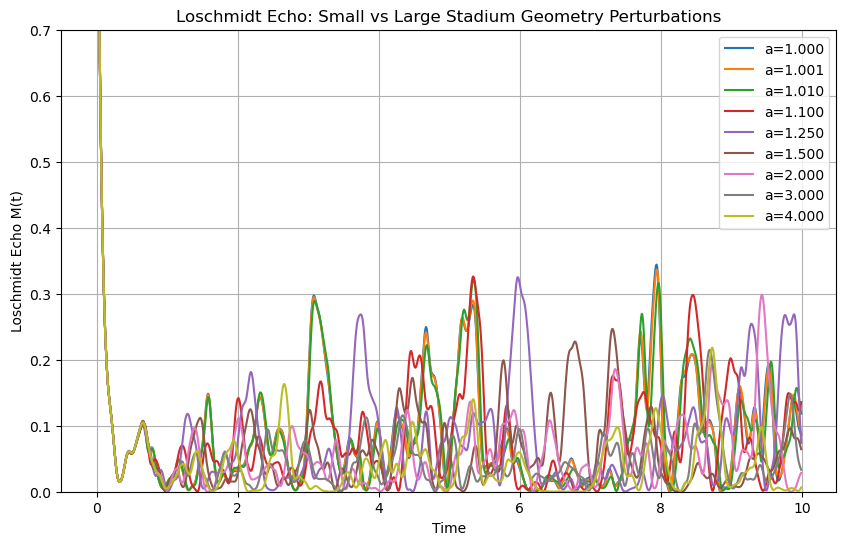

In [ ]:
dt = 0.01  # Decreased time step for finer evolution

# Compare Loschmidt echo for smaller and larger stadium geometry perturbations
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Parameters for echo
perturbations_a = [ a*1.0001,a*1.001,a*1.01,a*1.10, a*1.25,a*1.5, a*2.0, a*3.0,a*4.0]
factor = 1e-3
perturbations_a = [p * factor for p in perturbations_a] 
echo_steps = 1000
echo_results = {}

for a_p in perturbations_a:
    # Recompute mask and free points for perturbed stadium
    mask_pert = stadium_mask(X, Y, a_p, b, rx, ry)
    free_points_pert = np.where(mask_pert.flatten())[0]
    Nfree_pert = len(free_points_pert)

    # Project initial wavepacket to perturbed stadium
    psi0_pert = psi0_flat[free_points_pert]
    norm_init_pert = np.sum(np.abs(psi0_pert)**2) * dx * dy
    psi0_pert /= np.sqrt(norm_init_pert)

    # Build Laplacian and Hamiltonian for perturbed stadium
    mask_full_pert = np.zeros(Nx*Ny, dtype=bool)
    mask_full_pert[free_points_pert] = True
    rows_pert, cols_pert, data_pert = [], [], []
    for i, idx in enumerate(free_points_pert):
        rows_pert.append(i)
        cols_pert.append(idx)
        data_pert.append(1)
    P_pert = csr_matrix((data_pert, (rows_pert, cols_pert)), shape=(Nfree_pert, Nx*Ny))
    L_pert = P_pert @ L @ P_pert.T
    I_pert = eye(Nfree_pert)
    H_pert = - (hbar**2) / (2*m) * L_pert

    # Crank-Nicolson matrices for perturbed stadium
    A_pert = (I_pert + 1j * dt / (2*hbar) * H_pert).tocsc()
    B_pert = (I_pert - 1j * dt / (2*hbar) * H_pert).tocsc()
    LU_pert = splu(A_pert)

    # Loschmidt echo evolution
    psi_bwd = psi0_pert.copy()
    M_t = []
    for t in tqdm(range(echo_steps), desc=f'Loschmidt echo a={a_p:.3f}'):
        b_vec = B_pert @ psi_bwd
        psi_bwd = LU_pert.solve(b_vec)
        overlap = np.vdot(psi0_pert, psi_bwd) * dx * dy
        M_t.append(np.abs(overlap)**2)
    echo_results[a_p] = M_t

# Plot Loschmidt echo for all a perturbations
times_echo = np.arange(echo_steps) * dt

# Plot Loschmidt echo for all a perturbations with y-axis limited to 0.2
plt.figure(figsize=(10,6))
for a_p, M_t in echo_results.items():
    plt.plot(times_echo, M_t, label=f'a={a_p:.3f}')
plt.xlabel('Time')
plt.ylabel('Loschmidt Echo M(t)')
plt.title('Loschmidt Echo: Small vs Large Stadium Geometry Perturbations')
plt.ylim(0, 0.7)
plt.legend()
plt.grid(True)
plt.show()

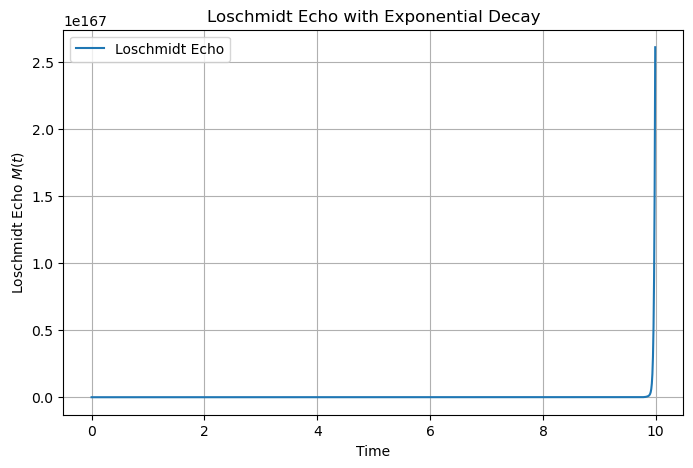

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 100  # Number of lattice points
dx = 1.0  # Lattice spacing
dt = 0.01  # Time step
hbar = 1.0  # Reduced Planck's constant
m = 1.0  # Mass
V0 = 0.1  # Perturbation strength
T_steps = 1000  # Number of time steps

# Define the 1D Laplacian operator
def laplacian_1d(N, dx):
    main_diag = -2.0 * np.ones(N)
    off_diag = np.ones(N - 1)
    L = np.diag(main_diag) + np.diag(off_diag, k=1) + np.diag(off_diag, k=-1)
    return L / dx**2

# Build the unperturbed Hamiltonian
Laplacian = laplacian_1d(L, dx)
H0 = -(hbar**2) / (2 * m) * Laplacian

# Add a small perturbation to the Hamiltonian
H_pert = H0 + V0 * np.diag(np.random.uniform(-1, 1, L))

# Initial Gaussian wave packet
x = np.linspace(-L // 2, L // 2, L)
sigma = 5.0
k0 = 2.0 * np.pi / L  # Initial momentum
psi0 = np.exp(-x**2 / (2 * sigma**2)) * np.exp(1j * k0 * x)
psi0 /= np.linalg.norm(psi0)  # Normalize the wavefunction

# Time evolution operators
U0 = np.linalg.matrix_power(np.eye(L) - 1j * dt / hbar * H0, T_steps)
U_pert = np.linalg.matrix_power(np.eye(L) - 1j * dt / hbar * H_pert, T_steps)

# Loschmidt echo calculation
M_t = []
psi_t = psi0.copy()
for t in range(T_steps):
    psi_t = U_pert @ psi_t  # Evolve under perturbed Hamiltonian
    overlap = np.vdot(psi0, psi_t)  # Compute overlap with initial state
    M_t.append(np.abs(overlap)**2)  # Loschmidt echo

# Time array
times = np.arange(T_steps) * dt

# Plot Loschmidt echo
plt.figure(figsize=(8, 5))
plt.plot(times, M_t, label="Loschmidt Echo")
plt.xlabel("Time")
plt.ylabel("Loschmidt Echo $M(t)$")
plt.title("Loschmidt Echo with Exponential Decay")
plt.grid(True)
plt.legend()
plt.show()

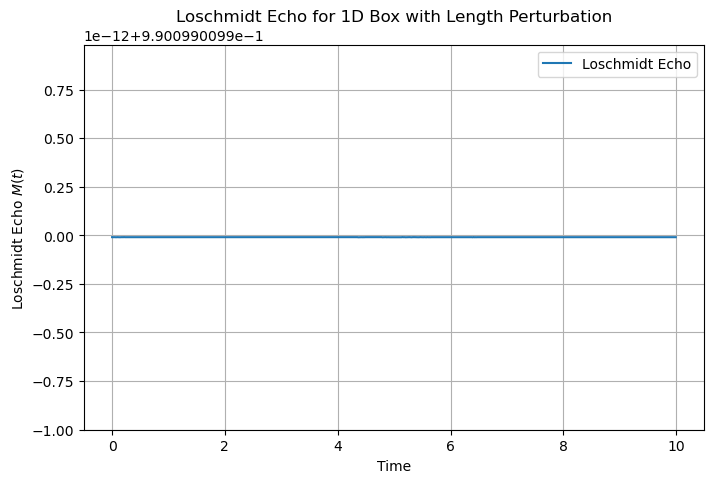

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 1.0  # Length of the unperturbed box
L_pert = 1.01 * L  # Length of the perturbed box (small perturbation)
hbar = 1.0  # Reduced Planck's constant
m = 1.0  # Mass of the particle
n = 1  # Quantum number of the initial state
T_steps = 1000  # Number of time steps
dt = 0.01  # Time step

# Define the energy eigenstates and eigenvalues for the box
def psi_box(x, n, L):
    """Wavefunction for the nth eigenstate in a box of length L."""
    return np.sqrt(2 / L) * np.sin(n * np.pi * x / L)

def energy_box(n, L):
    """Energy of the nth eigenstate in a box of length L."""
    return (n**2 * np.pi**2 * hbar**2) / (2 * m * L**2)

# Discretize the spatial domain
Nx = 500  # Number of spatial points
x = np.linspace(0, L, Nx)  # Spatial grid for the unperturbed box
x_pert = np.linspace(0, L_pert, Nx)  # Spatial grid for the perturbed box

# Initial wavefunction (unperturbed box)
psi0 = psi_box(x, n, L)

# Time evolution in the unperturbed box
E = energy_box(n, L)
omega = E / hbar  # Angular frequency
psi_t_unpert = lambda t: psi0 * np.exp(-1j * omega * t)

# Time evolution in the perturbed box
E_pert = energy_box(n, L_pert)
omega_pert = E_pert / hbar  # Angular frequency
psi_t_pert = lambda t: psi_box(x_pert, n, L_pert) * np.exp(-1j * omega_pert * t)

# Compute the Loschmidt echo
M_t = []
times = np.arange(T_steps) * dt
for t in times:
    # Overlap between the unperturbed and perturbed wavefunctions
    overlap = np.trapz(np.conj(psi_t_unpert(t)) * psi_t_pert(t), x)
    M_t.append(np.abs(overlap)**2)

# Plot the Loschmidt echo
plt.figure(figsize=(8, 5))
plt.plot(times, M_t, label="Loschmidt Echo")
plt.xlabel("Time")
plt.ylabel("Loschmidt Echo $M(t)$")
plt.title("Loschmidt Echo for 1D Box with Length Perturbation")
plt.grid(True)
plt.legend()
plt.show()

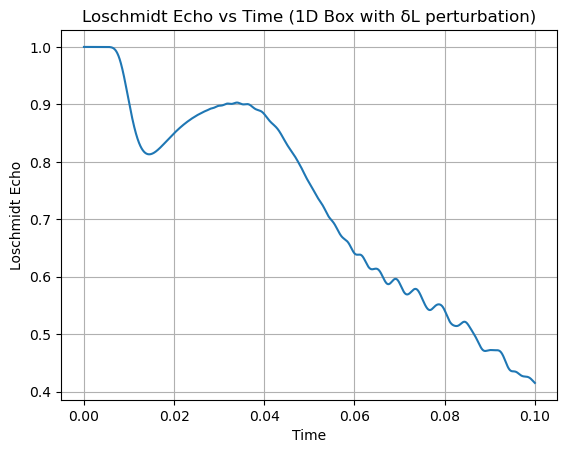

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Physical constants (in natural units for simplicity)
hbar = 1.0
m = 1.0

# Box parameters
L = 1.0           # original box length
delta_L = 0.01    # small perturbation in length
L_pert = L + delta_L

# Basis size
N_states = 100    # number of eigenstates to use

# Initial wavepacket parameters
x_points = 1000
x = np.linspace(0, L, x_points)
x0 = L / 2            # center of wavepacket
sigma = L / 20        # width of wavepacket
k0 = 10 * np.pi / L   # central wave number

# Construct initial wavepacket in position space
psi0_x = np.exp(-(x - x0)**2 / (2 * sigma**2)) * np.exp(1j * k0 * x)
psi0_x /= np.sqrt(np.trapz(np.abs(psi0_x)**2, x))  # normalize

# Eigenstates and energies
def phi_n(n, x, L_box):
    return np.sqrt(2 / L_box) * np.sin(n * np.pi * x / L_box)

def E_n(n, L_box):
    return (n * np.pi * hbar)**2 / (2 * m * L_box**2)

# Projection coefficients for unperturbed and perturbed systems
def get_coefficients(psi_x, L_box):
    coeffs = []
    for n in range(1, N_states + 1):
        phi = phi_n(n, x, L_box)
        c_n = np.trapz(np.conj(phi) * psi_x, x)
        coeffs.append(c_n)
    return np.array(coeffs)

c_n_unpert = get_coefficients(psi0_x, L)
c_n_pert = get_coefficients(psi0_x, L_pert)

# Time evolution
def psi_t(c_n, L_box, t):
    psi = np.zeros_like(x, dtype=complex)
    for n, c in enumerate(c_n, start=1):
        phi = phi_n(n, x, L_box)
        E = E_n(n, L_box)
        psi += c * phi * np.exp(-1j * E * t / hbar)
    return psi

# Loschmidt Echo over time
times = np.linspace(0, 0.1, 20000)
echo = []

for t in times:
    psi_unpert = psi_t(c_n_unpert, L, t)
    psi_pert = psi_t(c_n_pert, L_pert, t)
    
    # Back evolve psi_pert under H0
    c_n_pert_back = get_coefficients(psi_pert, L)
    psi_back = psi_t(c_n_pert_back, L, -t)
    
    # Loschmidt echo = |<ψ0 | ψ_back>|^2
    overlap = np.trapz(np.conj(psi0_x) * psi_back, x)
    echo.append(np.abs(overlap)**2)

# Plot
plt.plot(times, echo)
plt.xlabel("Time")
plt.ylabel("Loschmidt Echo")
plt.title("Loschmidt Echo vs Time (1D Box with δL perturbation)")
plt.grid(True)
plt.show()
